In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM,Conv3D

In [2]:
def data_handler(name):
    dataframe =pd.read_csv(name)
    dataframe['datetime'] = dataframe['year'].map(str) + '-' + dataframe['month'].map(str) + '-' + dataframe['day'].map(str)
    dataframe['datetime'] = pd.to_datetime(dataframe['datetime'])
    dataframe['datetime'] = dataframe['datetime'] + dataframe['hour'].apply(lambda x: np.timedelta64(x, 'h'))
    dataframe.set_index('datetime',inplace=True)
    dataframe.pop('TEMP')
    dataframe.pop('PRES')
    dataframe.pop('DEWP')
    dataframe.pop('RAIN')
    dataframe.pop('WSPM')
    dataframe.pop('No')
    dataframe.pop('year')
    dataframe.pop('month')
    dataframe.pop('day')
    dataframe.pop('wd')
    dataframe.pop('O3')
    dataframe.pop('hour')



    dataframe.pop('station')
    dataframe=dataframe.interpolate(methode='time')
   
    dataframe=dataframe.resample('D').mean()

    df = np.asarray(dataframe)
    return dataframe


In [73]:
X1=data_handler("PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [29]:
Channels1=X1.diff()
Channels1=Channels1.dropna()
Channels2=X1.diff(365)
Channels1=Channels1[364:]
Channels2=Channels2.dropna()

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X1)
ch1 = scaler.transform(Channels1)


In [31]:

ch3 = scaler.transform(Channels2)

In [32]:

ch2 = scaler.transform(X1[365:])

In [33]:
def to_supervised(data,dropNa = True,lag=12):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,13):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = 5
    df = df.values
    supervised_data = df[:,:5*12]

    return supervised_data

In [34]:
timeSteps = 12
supervised1 = to_supervised(pd.DataFrame(ch1),timeSteps)


In [35]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised1[:,:(features*timeSteps)]

x_train1 = X[:train_hours,:]
x_test1 = X[train_hours:len(X)-timeSteps,:]

print (x_train1.shape,x_test1.shape)

(900, 60) (172, 60)


In [36]:
supervised2 = to_supervised(pd.DataFrame(ch2),timeSteps)

In [37]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised2[:,:(features*timeSteps)]

x_train2 = X[:train_hours,:]
x_test2 = X[train_hours:len(X)-timeSteps,:]

print (x_train2.shape,x_test2.shape)

(900, 60) (172, 60)


In [38]:
supervised3 = to_supervised(pd.DataFrame(ch3),timeSteps)
features = 5
train_hours = 900
X = supervised3[:,:(features*timeSteps)]
print(X.shape)
x_train3 = X[:train_hours,:]
x_test3 = X[train_hours:len(X)-timeSteps,:]

print (x_train3.shape,x_test3.shape)

(1084, 60)
(900, 60) (172, 60)


In [39]:
X_train1 = x_train1.reshape(x_train1.shape[0], timeSteps, features)
X_test1 = x_test1.reshape(x_test1.shape[0], timeSteps, features)

In [40]:
X_train2 = x_train2.reshape(x_train2.shape[0], timeSteps, features)
X_test2 = x_test2.reshape(x_test2.shape[0], timeSteps, features)

In [41]:
X_train3 = x_train3.reshape(x_train3.shape[0], timeSteps, features)
X_test3 = x_test3.reshape(x_test3.shape[0], timeSteps, features)

In [43]:
import tensorflow as tf

In [44]:
y = X1[377:]
y=scaler.transform(y)

In [45]:
y=y[:,0]

In [46]:
y_train = y[:train_hours]
y_test = y[train_hours:len(y)-timeSteps]

In [42]:
X_train1.shape

(900, 12, 5)

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling1D, LSTM,Conv3D,Conv1D,TimeDistributed

In [67]:
first_channel = tf.keras.Input(shape=(12,5))
second_channel=tf.keras.Input(shape=(12,5))
third_channel=tf.keras.Input(shape=(12,5))



X1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=False))(first_channel)
X2=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=False))(second_channel)
X3=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=False))(third_channel)
X4=tf.concat([X1,X2,X3],axis=-1)



X11=Dense(1)(X4)

In [68]:
model=tf.keras.Model([first_channel,second_channel,third_channel],X11)

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 12, 5)]      0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 12, 5)]      0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 12, 5)]      0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 100)         22400       ['input_7[0][0]']                
 )                                                                                          

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit([X_train1,X_train2,X_train3],y_train, validation_data=([X_test1,X_test2,X_test3],y_test),epochs=2000, shuffle=False,callbacks=[ early_stopping])

Epoch 1/2000
29/29 [==============================] - 26s 205ms/step - loss: 0.0183 - val_loss: 0.0236
Epoch 2/2000
29/29 [==============================] - 1s 30ms/step - loss: 0.0126 - val_loss: 0.0208
Epoch 3/2000
29/29 [==============================] - 1s 35ms/step - loss: 0.0118 - val_loss: 0.0198
Epoch 4/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0112 - val_loss: 0.0193
Epoch 5/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0111 - val_loss: 0.0190
Epoch 6/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0109 - val_loss: 0.0189
Epoch 7/2000
29/29 [==============================] - 1s 37ms/step - loss: 0.0109 - val_loss: 0.0187
Epoch 8/2000
29/29 [==============================] - 1s 37ms/step - loss: 0.0108 - val_loss: 0.0186
Epoch 9/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0107 - val_loss: 0.0185
Epoch 10/2000
29/29 [==============================] - 1s 31ms/step - loss: 0.0107 - val_

In [70]:
model.evaluate([X_test1,X_test2,X_test3],y_test)

6/6 [==============================] - 0s 10ms/step - loss: 0.0177


0.017665795981884003

In [71]:
prediction=model.predict([X_test1,X_test2,X_test3])

6/6 [==============================] - 6s 12ms/step


In [74]:
X=X1['PM2.5']


In [75]:
X=np.asarray(X).reshape((X.shape[0],1))

In [76]:
scaler2 = MinMaxScaler()
scaler2.fit(X)



MinMaxScaler()

In [77]:
df_predi=pd.DataFrame(y_test)

rev_trans=scaler2.inverse_transform(df_predi)

df_final=pd.DataFrame(rev_trans)

In [78]:

rev_trans1=scaler2.inverse_transform(prediction)




In [79]:
df_final[["PM2.5_pred"]]=rev_trans1

In [80]:
df_final

,0,PM2.5_pred
0,17.625000,36.133789
1,31.166667,42.454895
2,17.437500,52.468655
3,6.166667,36.413483
4,11.833333,23.697079
...,...,...
167,104.458333,74.196701
168,92.916667,132.993622
169,182.833333,105.238800
170,227.625000,179.550720


In [81]:
df_final.head(30)

,0,PM2.5_pred
0,17.625000,36.133789
1,31.166667,42.454895
2,17.437500,52.468655
3,6.166667,36.413483
4,11.833333,23.697079
5,18.458333,27.594168
6,79.833333,36.583096
7,27.000000,79.714066
8,21.742188,26.332237
9,42.820312,41.933750


<AxesSubplot:>

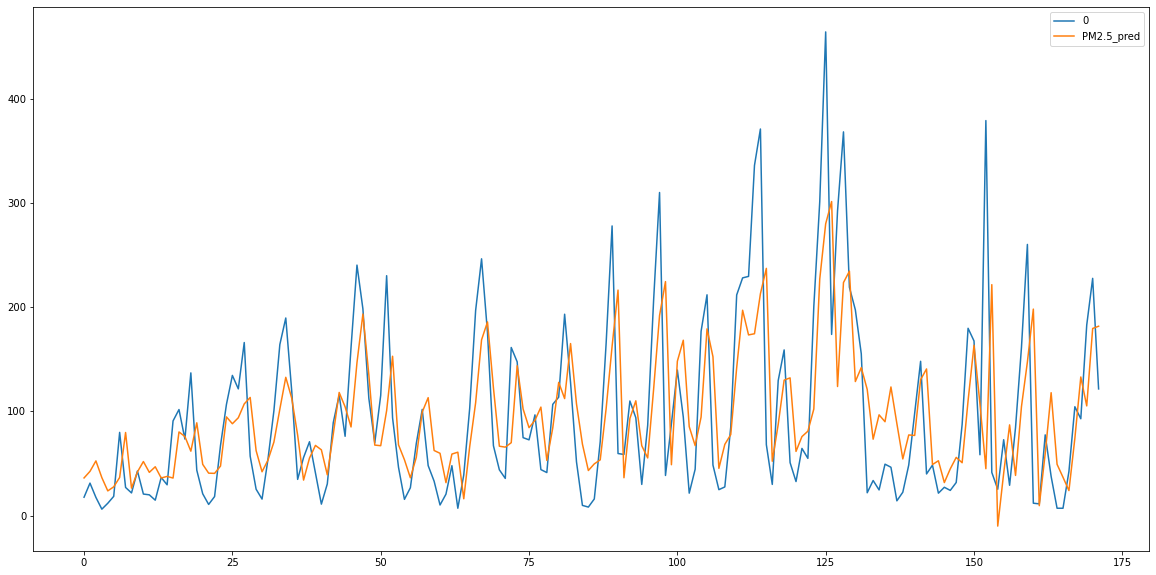

In [82]:
df_final[[0,"PM2.5_pred"]].plot(figsize=(20,10))

In [83]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(df_final[0], df_final["PM2.5_pred"]))
print('Test Score: %.2f RMSE' % (testScore))
#calculate mean aboslute error
mae=mean_absolute_error(df_final[0],df_final["PM2.5_pred"])
print('\nMae Score: %.2f ' % (mae))


Test Score: 67.58 RMSE

Mae Score: 48.55 


In [84]:
test_series = df_final[0]
# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
67.58 < 87.31


Text(0, 0.5, 'mse score')

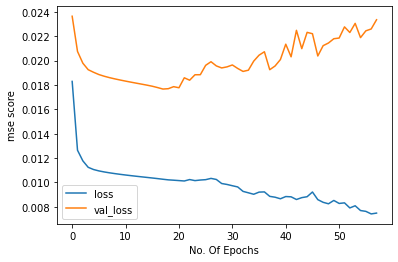

In [85]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [86]:
model.save('./modelbilstmulti-Uni')

INFO:tensorflow:Assets written to: ./modelbilstmulti-Uni\assets


INFO:tensorflow:Assets written to: ./modelbilstmulti-Uni\assets
